Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Loss: 1.5564, Accuracy: 40.93%
Epoch [2/10], Loss: 1.0785, Accuracy: 61.80%
Epoch [3/10], Loss: 0.8506, Accuracy: 70.94%
Epoch [4/10], Loss: 0.6945, Accuracy: 76.80%
Epoch [5/10], Loss: 0.5811, Accuracy: 80.79%
Epoch [6/10], Loss: 0.4891, Accuracy: 83.96%
Epoch [7/10], Loss: 0.4157, Accuracy: 86.40%
Epoch [8/10], Loss: 0.3497, Accuracy: 88.56%
Epoch [9/10], Loss: 0.2813, Accuracy: 90.81%
Epoch [10/10], Loss: 0.2434, Accuracy: 92.11%
Accuracy of the model on the 10000 test images: 83.89%


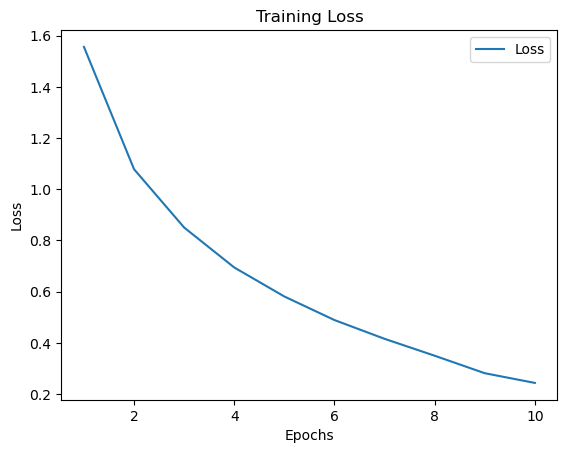

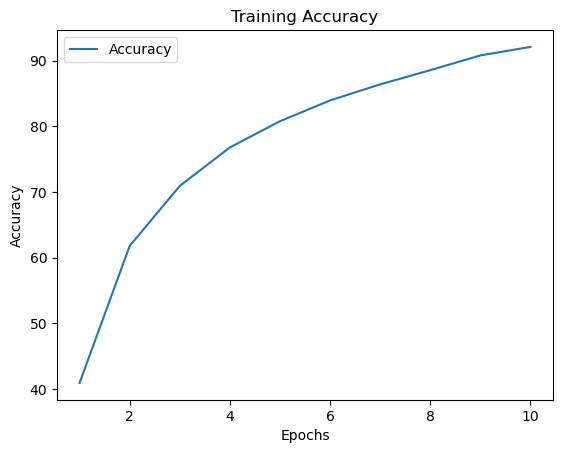

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
# TODO:解释参数含义，在?处填入合适的参数
batch_size = 64
learning_rate = 0.001
num_epochs = 10
 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
 
# root可以换为你自己的路径
trainset = torchvision.datasets.CIFAR10(root='D:/Dataset/CIFAR-10', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
 
testset = torchvision.datasets.CIFAR10(root='D:/Dataset/CIFAR-10', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        x = self.shortcut(x)
        return F.relu(x + y)

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        
        
        self.mp = nn.MaxPool2d(2)
        
       
        self.rblock1 = ResidualBlock(64, 64)
        self.rblock2 = ResidualBlock(128, 128)
        self.rblock3 = ResidualBlock(256, 256)
        self.rblock4 = ResidualBlock(512, 512)
        
        
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.mp(F.relu(self.bn1(self.conv1(x))))
        x = self.rblock1(x)
        x = self.mp(F.relu(self.bn2(self.conv2(x))))
        x = self.rblock2(x)
        x = self.mp(F.relu(self.bn3(self.conv3(x))))
        x = self.rblock3(x)
        x = self.mp(F.relu(self.bn4(self.conv4(x))))
        x = self.rblock4(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
 
# TODO:补全
model = Network().to(device)
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

losses = []
accuracies = []

def train():
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
 
            optimizer.zero_grad()
 
            outputs = model(inputs)
            loss = criterion(outputs, labels)
 
            loss.backward()
            optimizer.step()
 
            running_loss += loss.item()
 
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        avg_loss = running_loss / len(trainloader)
        accuracy = 100 * correct / total
        losses.append(avg_loss)
        accuracies.append(accuracy)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}, Accuracy: {accuracy:.2f}%')

epochs = np.arange(1, num_epochs+1)
def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
 
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f}%')
 
if __name__ == "__main__":
    train()
    test()


plt.figure()
plt.plot(epochs, losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# 绘制accuracy曲线图
plt.figure()
plt.plot(epochs, accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()